## Vega Mechanism Simulation

In [7]:
import numpy as np 
import matplotlib.pyplot as plt

from lib.function import MO_generator, VegaModel_Optimal, margin_calculator

# set parameter
T = 20
time_decimal = 2
dt = 1 / 10**time_decimal 
t = np.linspace(0, T, T*10**time_decimal+1)
t = np.round(t, time_decimal)

lambda_buy =  5
lambda_sell = 5
kappa = 10
q_upper = 20 
q_lower = -20 
phi = 1*10**-5
spread = 0.04

sigma = 1
s0 = 100 
x0 = 500

# Dynamic process
length = len(t)
dW = np.sqrt(dt)*np.random.randn(length-1)
S = np.zeros(length) # Midprice
S[0] = s0
P = np.zeros(length) # Markprice
P[0] = s0
Q = np.zeros(length) # Inventory
X = np.zeros(length) # Total collateral
X[0] = x0

# generate coming MO in time [0,T]
MOs_time = MO_generator(
    period=T,
    buy_mo_intensity=lambda_buy,
    sell_mo_intensity=lambda_sell,
    time_decimal=time_decimal,
)

# generate optimal depth
delta_buy, delta_sell, h = VegaModel_Optimal(
    T = T,
    dt = dt,
    q_upper = q_upper,
    q_lower = q_lower,
    kappa = kappa,
    Lambda_buy = lambda_buy,
    Lambda_sell= lambda_sell,
    phi = phi,
)

Assume $\epsilon^{\pm}$, which denotes the spread of limit order from other market participants, is a constant value of $\Delta / 2$, where $\Delta$ is the spread of best bid and best ask in the market. 

In [8]:
margin = []

for time_step in range(1, length):
    S[time_step] = S[time_step-1] + sigma*dW[time_step-1]
    # determine the depth of MM strategy
    buy_depth = delta_buy[time_step, int(q_upper - 1 - Q[time_step])] if Q[time_step-1] < q_upper else np.inf  
    sell_depth = delta_sell[time_step, int(q_upper - Q[time_step])] if Q[time_step-1] > q_lower else np.inf
    
    # MO coming
    if t[time_step] in MOs_time.index.values:

        if MOs_time.loc[t[time_step]][0] == 'sell':
            # sell MO coming, judge if the sell MO hits MM's buy LO
            prob = np.exp(- buy_depth * kappa)
            dN_t = np.random.binomial(1, prob)
            dA_t = 1 - dN_t
            # currently, we assume the epsilon is 0.5, later try to sample from a scaled-beta or normal distribution 
            epsilon = spread / 2

            # inventory process jumps 
            Q[time_step] = Q[time_step-1] + dN_t
            # mark price jumps
            P[time_step] = (S[time_step] - buy_depth) * dN_t + (S[time_step] - epsilon) * dA_t
        else:
            # buy MO coming
            prob = np.exp(- sell_depth * kappa)
            dN_t = np.random.binomial(1, prob)
            dA_t = 1 - dN_t
            epsilon = spread / 2

            # inventory process jump 
            Q[time_step] = Q[time_step-1] - dN_t
            # mark price jumps
            P[time_step] = (S[time_step] + sell_depth) * dN_t + (S[time_step] + epsilon) * dA_t

    # No MO coming
    else:
        P[time_step] = P[time_step-1]
        X[time_step] = X[time_step-1]
        Q[time_step] = Q[time_step-1]

    margin.append(margin_calculator(
                markprice=P[time_step],
                midprice=S[time_step],
                position=Q[time_step],
                buy_depth=buy_depth,
                sell_depth=sell_depth,
                risk_factor_long=0.336896,
                risk_factor_short=0.487873,
            ))
    # cash process updates
    X[time_step] = X[time_step-1] + Q[time_step-1]*(P[time_step]-P[time_step-1])

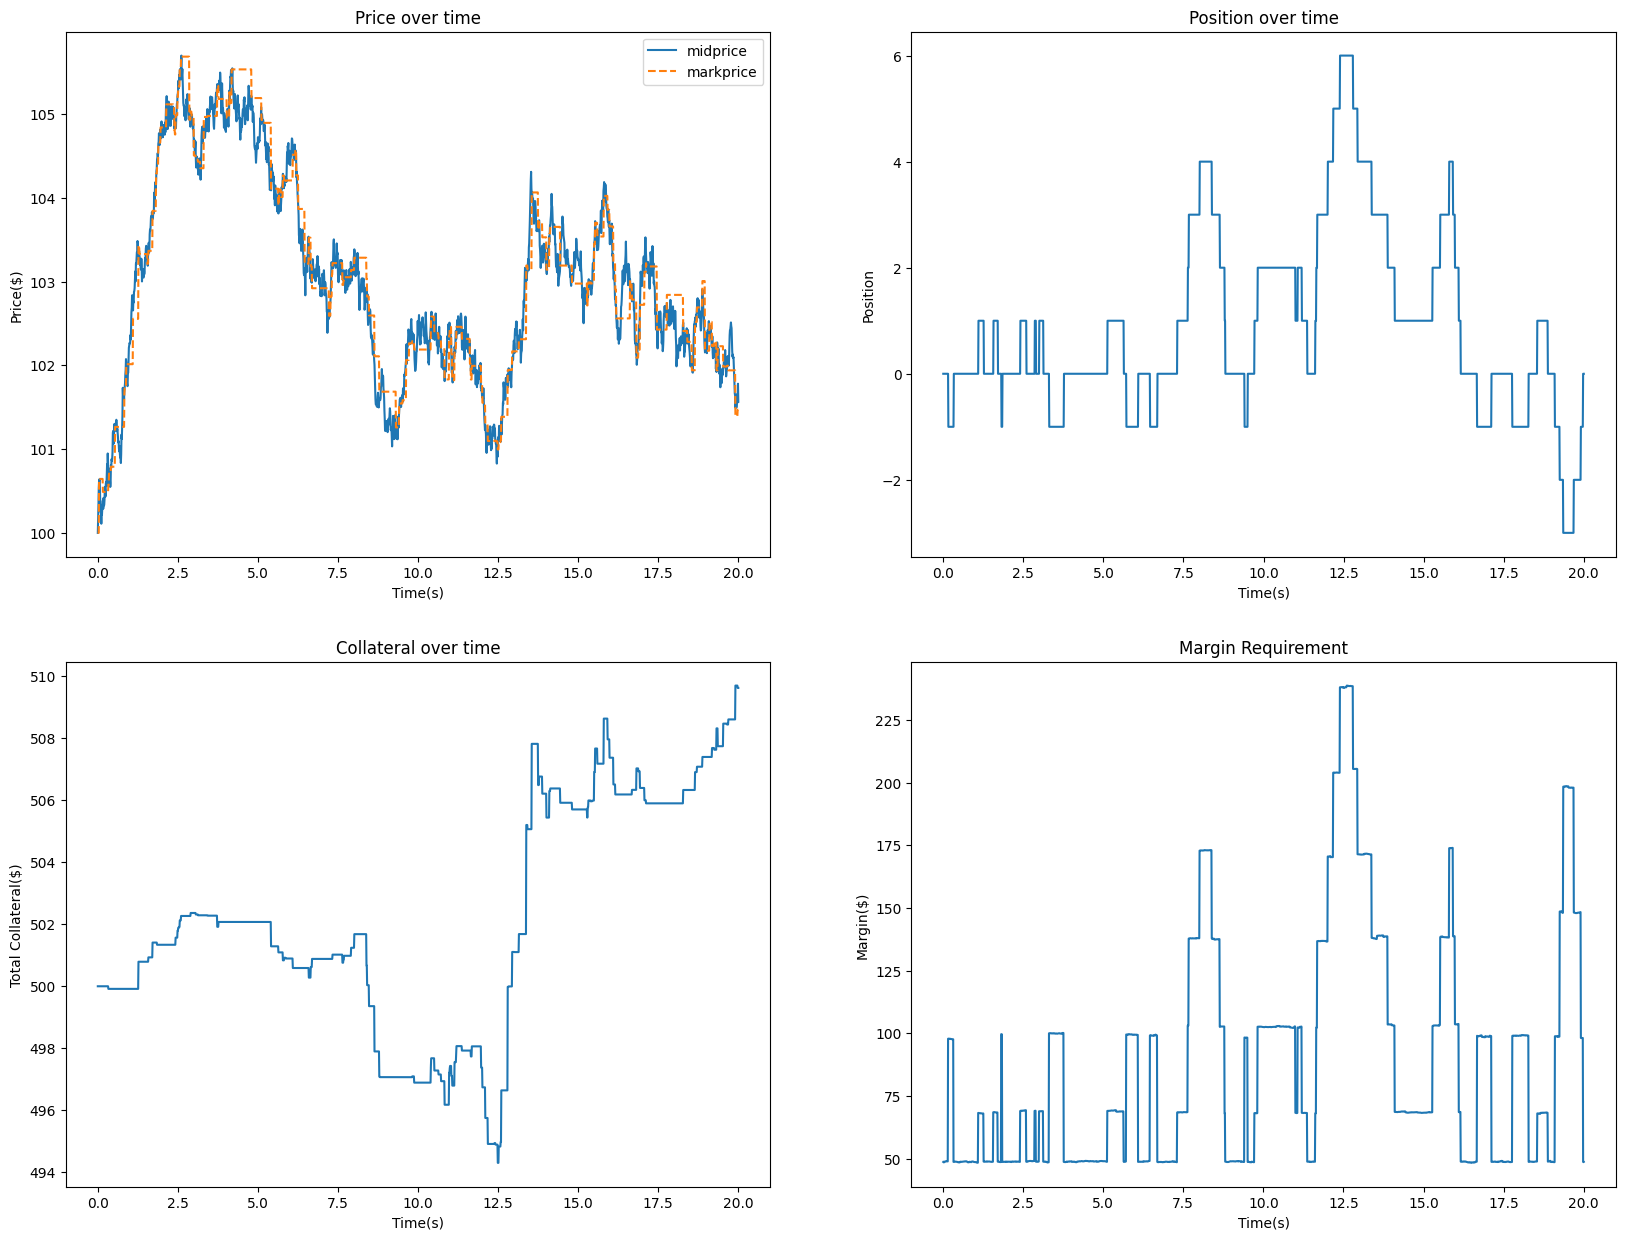

In [9]:
# Plot the performance

# Plot markprice & midprice
fig,ax = plt.subplots(2,2,figsize=(20,15))

ax[0,0].plot(t, S, label='midprice')
ax[0,0].plot(t, P, '--',label='markprice')
ax[0,0].set_title('Price over time')
ax[0,0].set_xlabel("Time(s)")
ax[0,0].set_ylabel("Price($)")
ax[0,0].legend()

ax[0,1].plot(t, Q)
ax[0,1].set_title('Position over time')
ax[0,1].set_xlabel("Time(s)")
ax[0,1].set_ylabel("Position")

ax[1,0].plot(t, X)
ax[1,0].set_title('Collateral over time')
ax[1,0].set_xlabel("Time(s)")
ax[1,0].set_ylabel("Total Collateral($)")


ax[1,1].plot(t[1:], margin)
ax[1,1].set_title('Margin Requirement')
ax[1,1].set_xlabel("Time(s)")
ax[1,1].set_ylabel("Margin($)")
plt.show()

## Controllability Simulation

To experimentally verify the controllability of the Vega mechanism, set the initial inventory $q = -10$. We would like to control the inventory level to $q^{'} = 0$ in a finite time period $T = 0.5$ with controls $\delta^{\pm}$ and a bounded collateral level $X$ without trigerring close-out. 

From the dynamic of the inventory, we have 
\begin{equation}
    T := \frac{q^{'} - q}{\lambda^{-} e^{-\kappa^{-} \delta^{-}} - \lambda^{+} e^{-\kappa^{+} \delta^{+}}}
\end{equation}

In [10]:
from lib.function import control_vegamodel, control_vega_torch
import numpy as np 
import matplotlib.pyplot as plt 

sigma = 0.1

lambda_buy = 50
lambda_sell = 50
kappa_buy, kappa_sell = 10, 10

q = -10
q_aim = 0
T = 0.5  
X0 = 500
S0 =10

buy = 0.05
sell = - np.log(((lambda_sell*np.exp(-kappa_buy*buy)) - (q_aim - q)/ T) / lambda_buy) / kappa_sell
print(f"If we'd like to control q=-10 to 0 in Time={T}, one of the feasible controls can be buy={buy}, sell={np.round(sell, 4)}.")

If we'd like to control q=-10 to 0 in Time=0.5, one of the feasible controls can be buy=0.05, sell=0.1577.


In [16]:
collateral, inventory, max_margin = control_vegamodel(
    S0 = S0,
    X0 = X0,
    q = q, 
    lambda_buy = lambda_buy,
    lambda_sell = lambda_sell,
    kappa_buy = kappa_buy,
    kappa_sell = kappa_sell,
    buy_depth = buy,
    sell_depth = sell,
    sigma = sigma,
    T = np.round(T, 3),
    time_decimal = 3,
    batch_size = 500, 
) 

print(f"Given the controls and running time, E[q(T)]={np.mean(inventory)}")

Given the controls and running time, E[q(T)]=-0.122


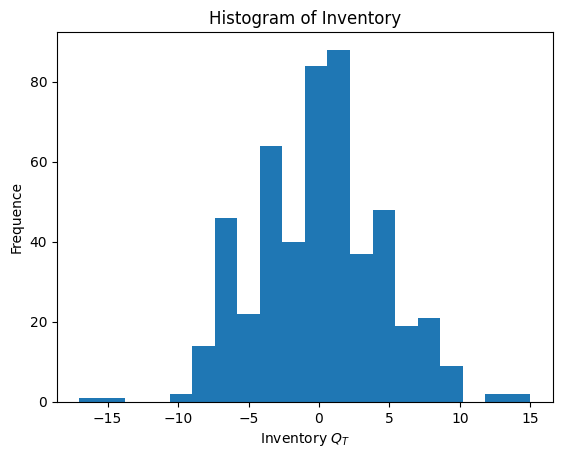

In [19]:
plt.hist(inventory, bins=20)
plt.title("Histogram of Inventory")
plt.ylabel("Frequence")
plt.xlabel("Inventory $Q_T$")

plt.show()

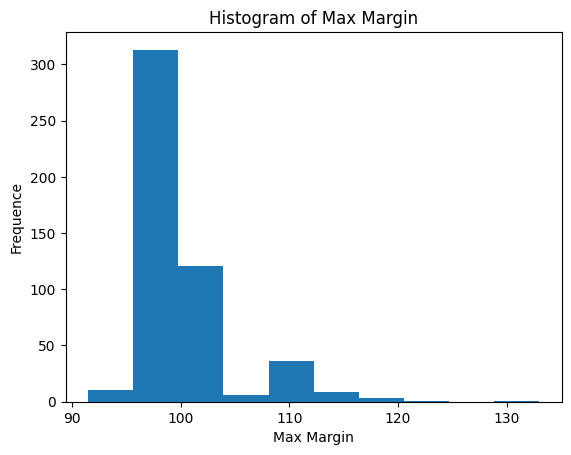

100.10086590607438

In [25]:
plt.hist(max_margin, bins=10)
plt.title("Histogram of Max Margin")
plt.xlabel("Max Margin")
plt.ylabel("Frequence")

plt.show()

np.mean(max_margin)

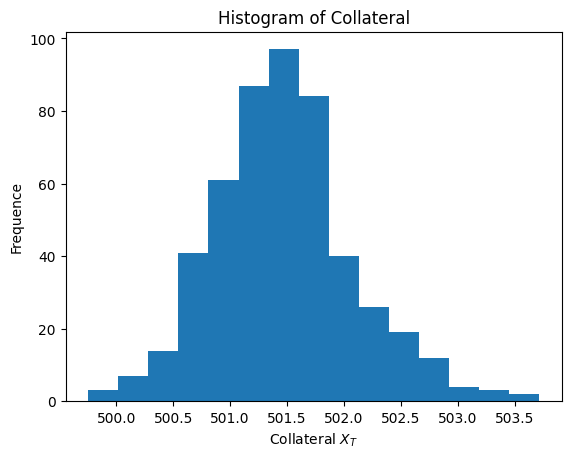

501.466660107325

In [28]:
plt.hist(collateral, bins=15)
plt.title("Histogram of Collateral")
plt.xlabel("Collateral $X_T$")
plt.ylabel("Frequence")
plt.show()

np.mean(collateral)

In [8]:
x = control_vega_torch(
    S0 = S0,
    X0 = X0,
    q = q, 
    lambda_buy = lambda_buy,
    lambda_sell = lambda_sell,
    kappa_buy = kappa_buy,
    kappa_sell = kappa_sell,
    buy_depth = buy,
    sell_depth = sell,
    sigma = sigma,
    T = np.round(T, 3),
    time_decimal = 3,
    batch_size = 10000, 
) 

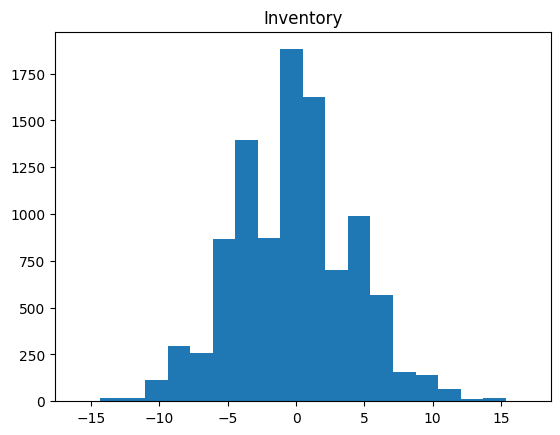

array(-0.186, dtype=float32)

In [30]:
plt.hist(x[:, -1, 3], bins=20)
plt.title("Inventory")
plt.show()

x[:, -1, 3].mean().numpy()

## Stability Simulation

In this simulation, we would like to find a compensated factor $\eta$ that satisfies $z^E = (Q, \tilde{X}^{\eta})$ is an equilibrium. 

In [7]:
from lib.function import control_vega_torch
import numpy as np 
import matplotlib.pyplot as plt 
import torch

sigma = 0.1

lambda_buy = 5
lambda_sell = 5
kappa_buy, kappa_sell = 10, 10

q = 0
T = 5  
X0 = 500
S0 =10

buy = 0.1
sell = 0.1

In [8]:
x = control_vega_torch(
    S0 = S0,
    X0 = X0,
    q = q, 
    lambda_buy = lambda_buy,
    lambda_sell = lambda_sell,
    kappa_buy = kappa_buy,
    kappa_sell = kappa_sell,
    buy_depth = buy,
    sell_depth = sell,
    sigma = sigma,
    T = T,
    time_decimal = 3,
    batch_size = 2000, 
) 

eta is: [0.3588058]


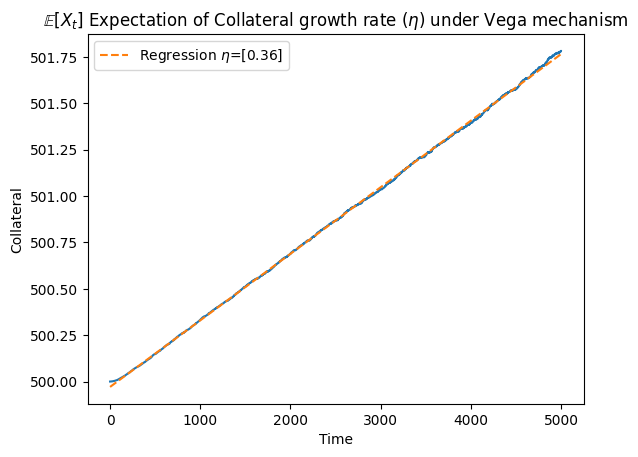

In [9]:
# Collateral

# find eta
from sklearn.linear_model import LinearRegression
T = 5
time_decimal = 3
T = int(T*10**time_decimal)

ts = torch.linspace(0, T, T+1) / 10**time_decimal
ts = torch.round(ts, decimals=time_decimal)
ts = ts.numpy()



l = LinearRegression(fit_intercept=True).fit(X = ts.reshape(-1,1), y = torch.mean(x[:, :, 0], axis=0).numpy().reshape(-1,1))
eta = l.coef_[0]


print("eta is:", eta)

plt.plot(torch.mean(x[:, :, 0], axis=0), label="")
plt.plot(l.predict(ts.reshape(-1,1)),'--', label=f"Regression $\eta$={np.round(eta,2)}")
plt.ylabel("Collateral")
plt.xlabel("Time")
plt.title("$\mathbb{E}[X_t] $ Expectation of Collateral growth rate ($\eta$) under Vega mechanism")
plt.legend()
plt.show()


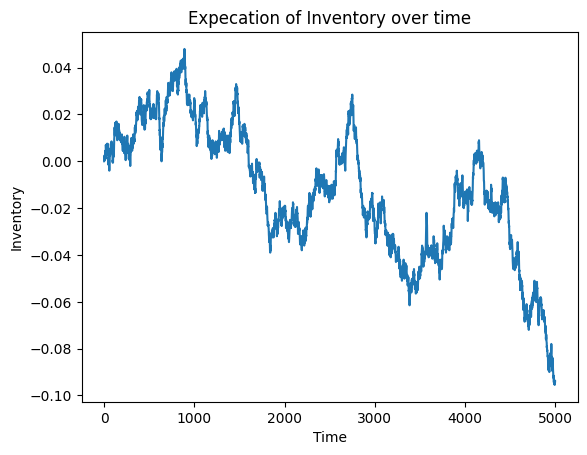

In [12]:
# Inventory 
plt.plot(torch.mean(x[:, :, 3], axis=0))
plt.ylabel("Inventory")
plt.xlabel("Time")
plt.title("Expecation of Inventory over time")
plt.show()

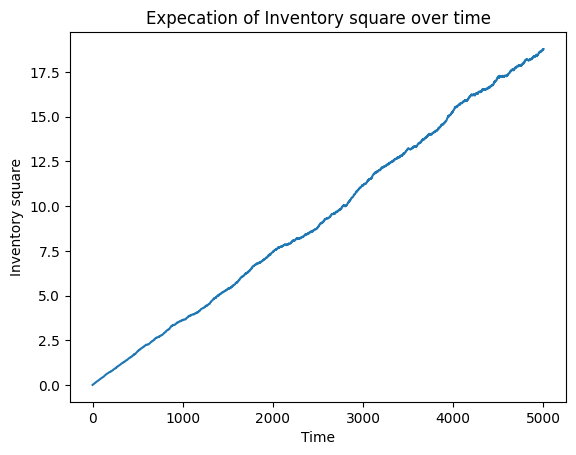

In [13]:
# Inventory square
plt.plot(torch.mean(x[:, :, 4], axis=0))
plt.ylabel("Inventory square")
plt.xlabel("Time")
plt.title("Expecation of Inventory square over time")
plt.show()